# [Building a Sample Neural Network](https://medium.com/@curiousily/tensorflow-for-hackers-part-ii-building-simple-neural-network-2d6779d2f91b)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams

%matplotlib inline

### Some styling and making our experiments reproducible:

In [0]:
sns.set(style='ticks', palette='Spectral', font_scale=1.5)

material_palette = ["#4CAF50", "#2196F3", "#9E9E9E", "#FF9800", "#607D8B", "#9C27B0"]
sns.set_palette(material_palette)
rcParams['figure.figsize'] = 16, 8

plt.xkcd();
random_state = 42
np.random.seed(random_state)
tf.set_random_seed(random_state)

## 1. Preparing the data

In [0]:
math_df = pd.read_csv("drive/My Drive/ML/data/student_alcohol_consumption/student-mat.csv", sep=",")
port_df = pd.read_csv("drive/My Drive/ML/data/student_alcohol_consumption/student-por.csv", sep=",")

In [5]:
math_df.head()
math_df.shape

(395, 33)

In [6]:
math_df["course"] = "math"
port_df["course"] = "portuguese"

merged_df = math_df.append(port_df)

merged_df.head()
merged_df.shape

(1044, 34)

The merged dataset contains 382 duplicate instances. We'll update the course column of those students

In [0]:
merge_vector = ["school","sex","age","address",
                "famsize","Pstatus","Medu","Fedu",
                "Mjob","Fjob","reason","nursery","internet"]

duplicated_mask = merged_df.duplicated(keep=False, subset=merge_vector)
duplicated_df = merged_df[duplicated_mask]
unique_df = merged_df[~duplicated_mask]
both_courses_mask = duplicated_df.duplicated(subset=merge_vector)
both_courses_df = duplicated_df[~both_courses_mask].copy()
both_courses_df["course"] = "both"
students_df = unique_df.append(both_courses_df)

We will use the following formula to quantify the amount of alcohol taken during the week per student:
    
![](https://miro.medium.com/max/594/1*CpeTU01Sm4PKdWyKdmESxA.png)

The new value changes in the interval . Furthermore, we will classify student as a drinker if that value is greater than 2.

In [0]:
students_df = students_df.sample(frac=1)
students_df['alcohol'] = (students_df.Walc * 2 + students_df.Dalc * 5) / 7
students_df['alcohol'] = students_df.alcohol.map(lambda x: ceil(x))
students_df['drinker'] = students_df.alcohol.map(lambda x: "yes" if x > 2 else "no")

# 2. Exploration

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


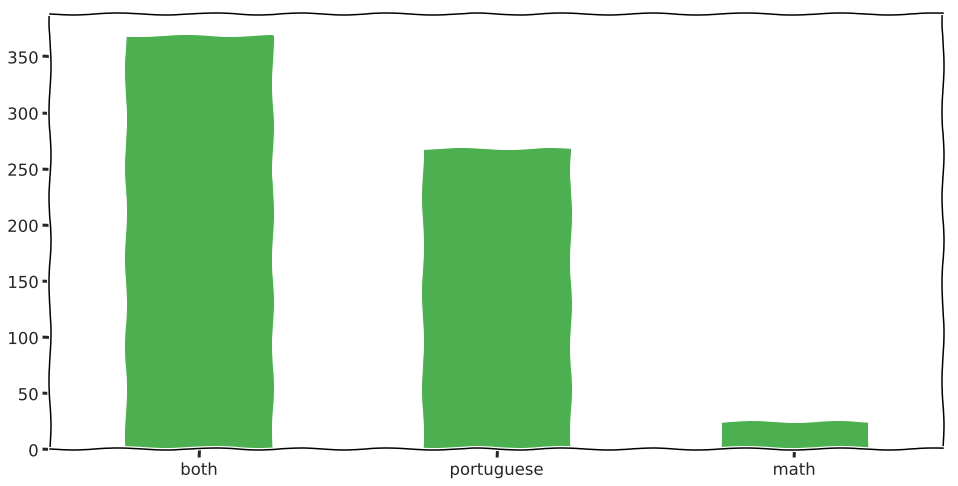

In [9]:
students_df.course.value_counts().plot(kind="bar", rot=0);

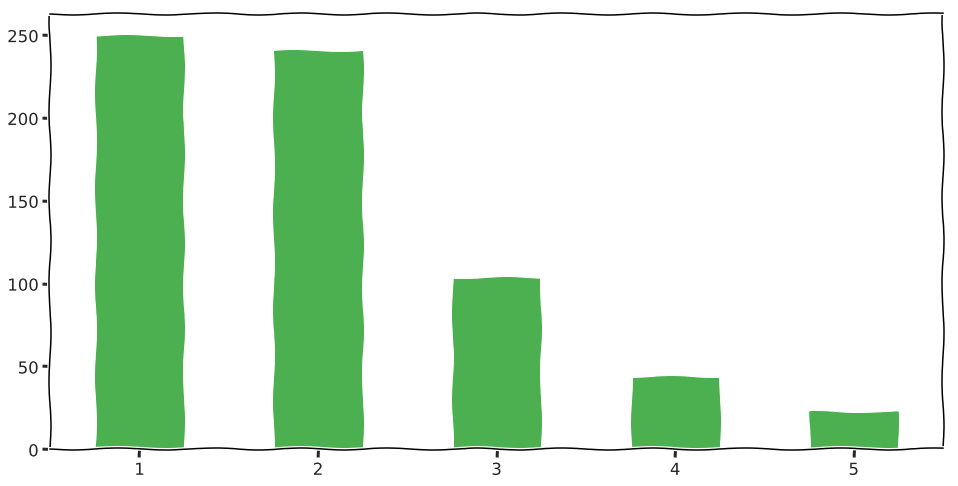

In [10]:
students_df.alcohol.value_counts().plot(kind="bar", rot=0);

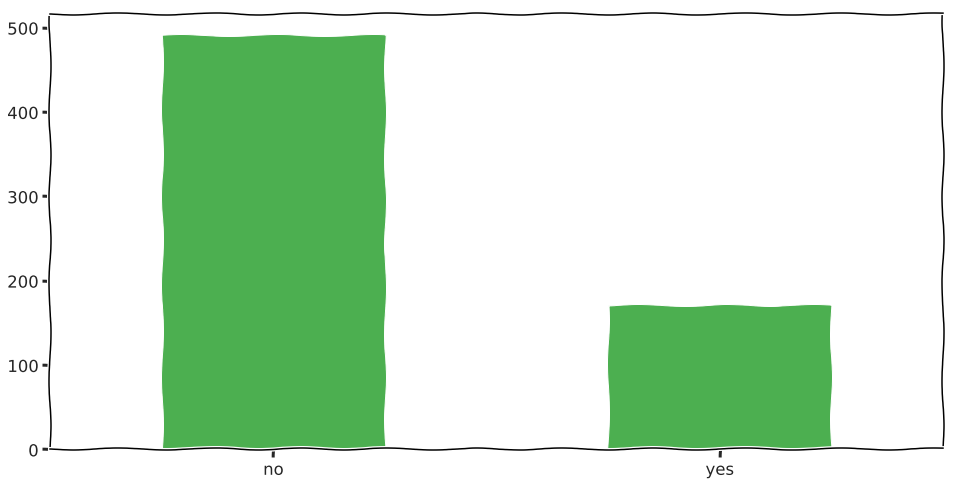

In [11]:
students_df.drinker.value_counts().plot(kind="bar", rot=0);

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


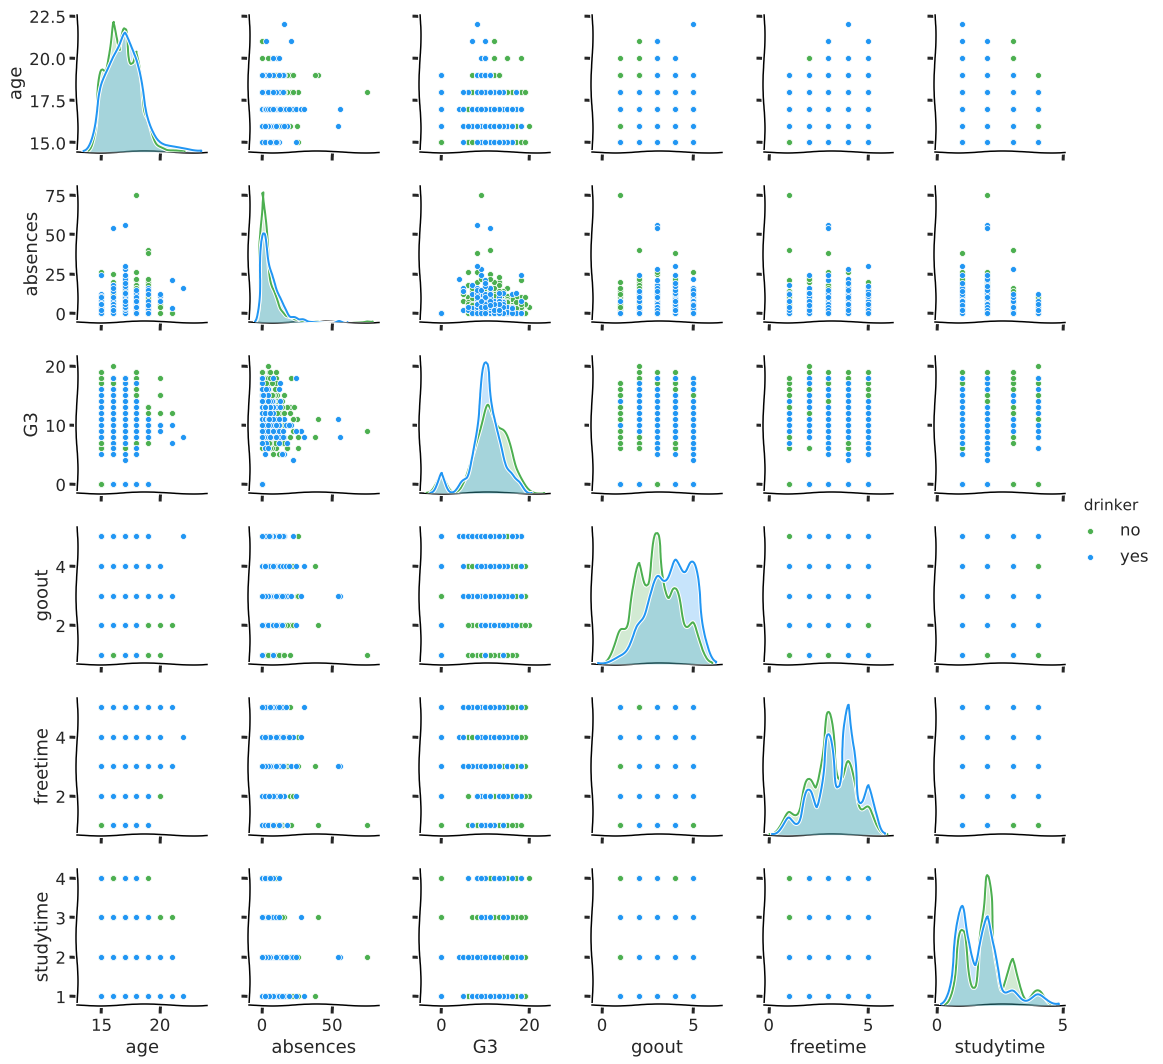

In [12]:
sns.pairplot(students_df[['age', 'absences', 'G3', 'goout', 'freetime', 'studytime', 'drinker']], hue='drinker');

### General correlations matrix:

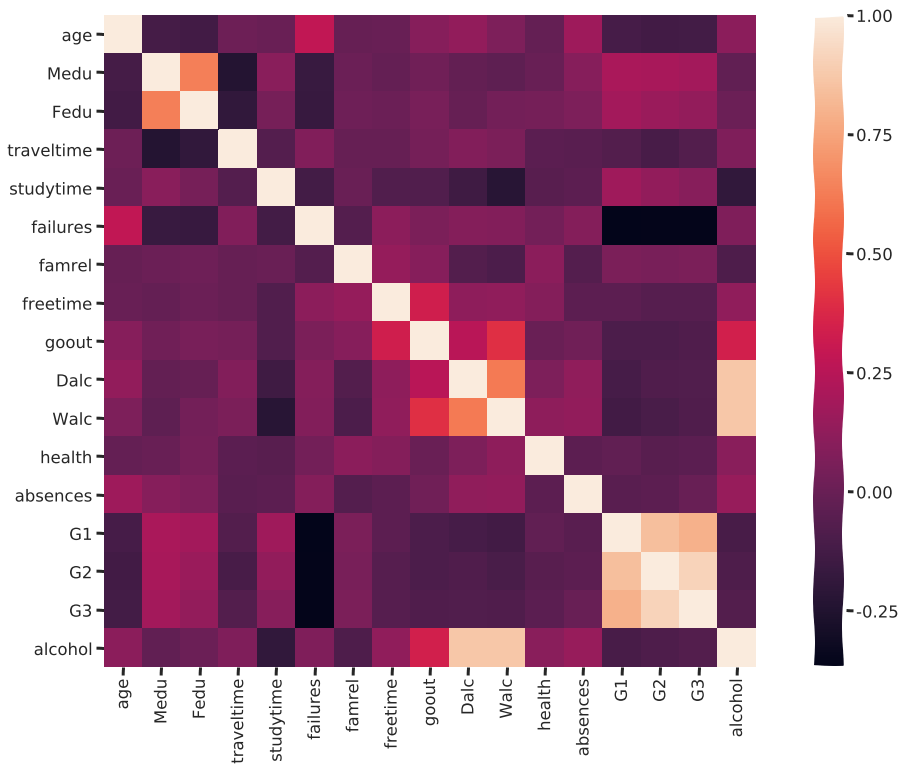

In [13]:
corr_mat = students_df.corr() 
fig, ax = plt.subplots(figsize=(20, 12)) 
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax);

# 3. Building our model

## 3.1 Encoding the data

Most of our variables are categorical and we must one-hot encode them four our NN to work properly

In [0]:
def encode(series): 
    # 'get_dummies' => Convert categorical variable into dummy/indicator variables
  return pd.get_dummies(series.astype(str))

In [0]:
train_x = pd.get_dummies(students_df.school)
train_x['age'] = students_df.age
train_x['absences'] = students_df.absences
train_x['g1'] = students_df.G1
train_x['g2'] = students_df.G2
train_x['g3'] = students_df.G3
train_x = pd.concat([train_x, encode(students_df.sex), encode(students_df.Pstatus), 
                     encode(students_df.Medu), encode(students_df.Fedu),
                     encode(students_df.guardian), encode(students_df.studytime),
                     encode(students_df.failures), encode(students_df.activities),
                     encode(students_df.higher), encode(students_df.romantic),
                     encode(students_df.reason), encode(students_df.paid),
                     encode(students_df.goout), encode(students_df.health),
                     encode(students_df.famsize), encode(students_df.course)
                    ], axis=1)

train_y = encode(students_df.drinker)

## 3.2 Splitting the data

In [0]:
train_size = 0.9

train_cnt = floor(train_x.shape[0] * train_size)
x_train = train_x.iloc[0:train_cnt].values
y_train = train_y.iloc[0:train_cnt].values
x_test = train_x.iloc[train_cnt:].values
y_test = train_y.iloc[train_cnt:].values

## 3.3 Building our Neural Network
Our NN consists of input, output and 1 hidden layer. We are using ReLU as activation function of the hidden layer and softmax for our output layer. As an additional bonus we will use Dropout — simple way to reduce overfitting during the training of our network.

In [0]:
def multilayer_perceptron(x, weights, biases, rate):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.dropout(layer_1, rate)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

Let’s set the number of neurons in the hidden layer to 38 and randomly initialize the weights and biases considering their proper dimensions:

In [0]:
n_hidden_1 = 38
n_input = train_x.shape[1]
n_classes = train_y.shape[1]

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

rate = tf.placeholder("float")

We will train our model for 5,000 epochs (training steps) with a batch size of 32. That is, at each step, we will train our NN using 32 rows of our data. Granted, in our case you can just train on the whole dataset. However, when the data is huge and you can’t fit it in memory, you would love to split it and feed it to the model at batches (chunks):

In [0]:
training_epochs = 5000
display_step = 1000
batch_size = 64

x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

## 3.4 Training

The cost function that we are going to use is called `Cross-Entropy`. It is defined as:
    
![](https://miro.medium.com/max/437/1*FU9AZn-z53NFPVY92pyLdQ.png)


Where `y` is the predicted distribution for our alcohol consumption and `y’` is the ground truth. TensorFlow has a little helper function with the sweet little name `softmax_cross_entropy_with_logits`. It uses `softmax` as activation function for our output layer and `Cross-Entropy` as error function.

`Adam` is a type of gradient descent optimization algorithm which essentially tries as hard as he can to find proper weights and biases for our network via minimizing the cost function that we specified above.



In [0]:
# Model Creation
predictions = multilayer_perceptron(x, weights, biases, rate)

# Cost-Function
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predictions, labels=y))

# Cost-Function Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

Our finished NN looks something like this (much reduced input and hidden layer sizes):
![](https://miro.medium.com/max/603/1*lt_Lo9DQqZ7Kf1GRiofNZw.png)

# 4. Evaluation

Time to see how well our model can predict. During the training, we will set the keep probability of the `Dropout` to 0.8 and reset it to 1.0 during test time:

In [24]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs):
        avg_cost = 0.0
        total_batch = int(len(x_train)/ batch_size)
        x_batches = np.array_split(x_train, total_batch)
        y_batches = np.array_split(y_train, total_batch)
        
        for i in range(total_batch):
            batch_x, batch_y = x_batches[i], y_batches[i]
            
            _, c = sess.run([optimizer, cost], 
                           feed_dict={
                               x: batch_x,
                               y: batch_y,
                               rate: 0.8
                           })
            avg_cost += c/total_batch
            
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
            
    print("Optimization Finished!")

    correct_prediction = tf.equal(tf.arg_max(predictions, 1), tf.arg_max(y, 1))

    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    print("Accuracy:", accuracy.eval({x: x_test, y: y_test, rate: 1.0}))     
    

Epoch: 0001 cost= 88.505346510
Epoch: 1001 cost= 3.376961867
Epoch: 2001 cost= 0.601669735
Epoch: 3001 cost= 0.411399547
Epoch: 4001 cost= 0.419682630
Optimization Finished!
Accuracy: 0.7164179
